<a href="https://colab.research.google.com/github/ahmdxrzky/capstone-bangkit-2022/blob/main/script/script_for_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREPARATION

Import important libraries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import os
import shutil
import tensorflow as tf
import pathlib
import tensorflow_hub as hub

Import train and test dataset from github.


In [ ]:
import zipfile

#Access github that contains dataset through this link
!wget --no-check-certificate \
    "https://codeload.github.com/ahmdxrzky/capstone-bangkit-2022/zip/refs/heads/main" \
    -O "/content/github.zip"

#Extract all files from github
zip_ref = zipfile.ZipFile('/content/github.zip', 'r')
zip_ref.extractall('/content/github')
zip_ref.close()

#Extract folder that contains dataset of images
zip_ref = zipfile.ZipFile('/content/github/capstone-bangkit-2022-main/dataset/spices.zip', 'r')
zip_ref.extractall('/content/spices')
zip_ref.close()

#Delete unnecessary files
os.remove('/content/github.zip')
shutil.rmtree('/content/github')

--2022-06-06 03:32:01--  https://codeload.github.com/ahmdxrzky/capstone-bangkit-2022/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/github.zip’

/content/github.zip     [           <=>      ]  11.50M  4.91MB/s    in 2.3s    

2022-06-06 03:32:04 (4.91 MB/s) - ‘/content/github.zip’ saved [12058851]



Load images from extracted dataset's folder and use its names as labels, both for train and test.

In [ ]:
#Access images and used its folder names as label using flow_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

try:
  os.rmdir("/content/spices/TRAINING_DIR/.ipynb_checkpoints")
  os.rmdir("/content/spices/TEST_DIR/.ipynb_checkpoints")
except FileNotFoundError:
  pass

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(directory="/content/spices/TRAINING_DIR",
                                                    target_size=(224,224),
                                                    batch_size=10,
                                                    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = train_datagen.flow_from_directory(directory="/content/spices/TESTING_DIR",
                                                   target_size=(224,224),
                                                   batch_size=10,
                                                   class_mode='categorical')

Found 1506 images belonging to 6 classes.
Found 300 images belonging to 6 classes.


In [ ]:
train_generator.class_indices

{'JAHE': 0, 'KEMIRI': 1, 'KENCUR': 2, 'KUNYIT': 3, 'LENGKUAS': 4, 'PALA': 5}

Define callback to stop training when its accuracy exceeds 98%.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') is not None and logs.get('acc') > 0.98:
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

# PRE TRAINED MODEL - INCEPTION

Load InceptionV3 weight file and use it to the InceptionV3 pre-trained model.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-02 02:43:15--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.1.128, 108.177.120.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   319MB/s    in 0.3s    

2022-06-02 02:43:15 (319 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

Build an instance of pre-trained model.

In [ ]:
pre_trained_model = InceptionV3(input_shape = (224, 224, 3),
                                include_top = False, 
                                weights = None) 

pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 111, 111, 32  96         ['conv2d_282[0][0]']             
 Normalization)                 )                                                      

# MODEL TRAINING

Cut the pre-trained model only to "mixed7" layer and add Flatten layer, hidden layer, dropout layer, and output layer to the model.

In [ ]:
last_layer = pre_trained_model.get_layer("mixed7")
last_layer_output = last_layer.output

x = tf.keras.layers.Flatten()(last_layer_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

Compile the model.

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

Train the model.

In [ ]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 98% accuracy
history = model.fit(train_generator,
                    validation_data = test_generator,
                    epochs = 20,
                    verbose = 2,
                    callbacks=[callbacks])

Epoch 1/20
151/151 - 11s - loss: 4.0801 - acc: 0.6886 - val_loss: 0.5599 - val_acc: 0.8633 - 11s/epoch - 76ms/step
Epoch 2/20
151/151 - 8s - loss: 0.2473 - acc: 0.9416 - val_loss: 0.3425 - val_acc: 0.9033 - 8s/epoch - 52ms/step
Epoch 3/20
151/151 - 8s - loss: 0.2249 - acc: 0.9582 - val_loss: 0.5252 - val_acc: 0.9000 - 8s/epoch - 52ms/step
Epoch 4/20
151/151 - 8s - loss: 0.2063 - acc: 0.9602 - val_loss: 0.6111 - val_acc: 0.8767 - 8s/epoch - 51ms/step
Epoch 5/20

Reached 98% accuracy so cancelling training!
151/151 - 8s - loss: 0.0918 - acc: 0.9854 - val_loss: 0.7704 - val_acc: 0.8567 - 8s/epoch - 51ms/step


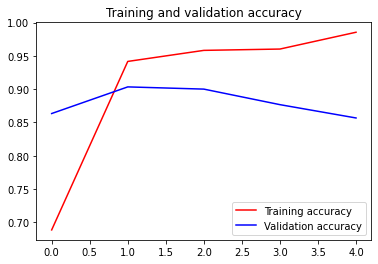

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# EXPORT MODEL

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Create a labels.txt file with the class names
class_names = ['Jahe', 'Kemiri', 'Kencur', 'Kunyit', 'Lengkuas', 'Pala']

with open('/content/drive/Shareddrives/CAPSTONE_BANGKIT/model/labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [ ]:
# Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model/1'

tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1/assets


# EXPORT MODEL - h5

In [ ]:
model.save("/content/drive/Shareddrives/CAPSTONE_BANGKIT/model/spice_model.h5")

# EXPORT MODEL - tflite

In [ ]:
import tensorflow as tf
import shutil

shutil.rmtree("/content/spices")
shutil.rmtree("/content/sample_data")

In [ ]:
# Select mode of optimization
mode = " " 

import tensorflow as tf
if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [ ]:
# Use the TFLiteConverter SavedModel API to initialize the converter
export_dir = 'saved_model/1'
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimizations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('/content/drive/Shareddrives/CAPSTONE_BANGKIT/model/spice_model.tflite')
tflite_model_file.write_bytes(tflite_model)

from google.colab import files
files.download('/content/drive/Shareddrives/CAPSTONE_BANGKIT/model/spice_model.tflite')

#  ADDING METADATA

In [ ]:
!pip install absl-py
!pip install tensorflow
!pip install tflite-support
!pip install protobuf==3.18
!pip install flatbuffers==1.12

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.5 MB 1.2 MB/s 
     |████████████████████████████████| 1.0 MB 49.3 MB/s 
     |████████████████████████████████| 213 kB 74.3 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.9 MB/s 
Reason for being yanked: This version claims to support Python 2 but does not
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.1
    Uninstalling protobuf-3.20.1:
      Successfully uninstalled protobuf-3.20.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!sudo apt-get install libportaudio2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  libportaudio2
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 64.6 kB of archives.
After this operation, 215 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Fetched 64.6 kB in 0s (131 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


In [ ]:
!python /content/drive/Shareddrives/CAPSTONE_BANGKIT/metadata_writer_for_image_classifier.py \
    --model_file=/content/drive/Shareddrives/CAPSTONE_BANGKIT/model/spice_model.tflite \
    --label_file=/content/drive/Shareddrives/CAPSTONE_BANGKIT/model/labels.txt \
    --export_directory=/content/drive/Shareddrives/CAPSTONE_BANGKIT/model_with_metadata

Finished populating metadata and associated file to the model:
/content/drive/Shareddrives/CAPSTONE_BANGKIT/model/spice_model.tflite
The metadata json file has been saved to:
/content/drive/Shareddrives/CAPSTONE_BANGKIT/model_with_metadata/spice_model.json
The associated file that has been been packed to the model is:
['labels.txt']
